In [ ]:
from nbdev import *
%nbdev_default_export functions

Cells will be exported to pct.functions,
unless a different module is specified after an export flag: `%nbdev_export special.module`


In [ ]:
%nbdev_hide
%reload_ext autoreload
%autoreload 2

In [ ]:
%nbdev_hide
import sys
sys.path.append("..")

# Functions

> Functions that form the elements of a perceptual control node (system).


## Overview
Each function outputs the result of applying the function logic and may be a scalar or array, depending on the input. The inputs are supplied as links to another function, from where the values are read. Unless the function is a simple case, such as a 'Constant'. 

Parameters are supplied as arguments to the constructor of the class.

All functions include the methods defined by the BaseFunction class.

In [ ]:
%nbdev_export
import numpy as np
import gym
import json
import math
import networkx as nx
from abc import ABC, abstractmethod
from pct.putils import sigmoid
from pct.putils import UniqueNamer
from pct.putils import FunctionsList

In [ ]:
%nbdev_export
class BaseFunction(ABC):
    "Base class of a PCT function. This class is not used direclty by developers, but defines the functionality common to all."
    def __init__(self, name, value, links=None, new_name=True):
        self.value = value
        self.links = []
        self.handle_links(links)
        self.checklinks=True
                
        #print(f'size {len(UniqueNamer.getInstance().names)} {name} {name in UniqueNamer.getInstance().names}', end=" ")
        if new_name:
            self.name = UniqueNamer.getInstance().get_name(name)
        else:
            self.name = name                
        #print(self.name)
        FunctionsList.getInstance().add_function(self)
        self.decimal_places = 3
        
    @abstractmethod
    def __call__(self, verbose=False):
        if verbose :
            print(self.output_string(), end= " ")
            
        return self.value
    
    def run(self, steps=None, verbose=False):
        for i in range(steps):
            out = self(verbose)
        return out
    
    def handle_links(self, links):
        if links!=None:
            if isinstance(links, dict):
                if len(links)>0:
                    for key in links.keys():
                        self.links.append(FunctionsList.getInstance().get_function(links[key]))
                return

            if isinstance(links, list):
                for link in links:
                    if isinstance(link, str):
                        self.links.append(FunctionsList.getInstance().get_function(link))
                    else:
                        self.links.append(link)
                return
        
            if isinstance(links, str):
                self.links.append(FunctionsList.getInstance().get_function(links))
                return
            
            self.links.append(links)
                
    def draw(self, with_labels=True,  font_size=12, font_weight='bold', node_color='red',  
             node_size=500, arrowsize=25, align='horizontal', file=None):
        graph = self.graph(layer=0, layer_edges=True)
        pos = nx.multipartite_layout(graph, subset_key="layer", align=align)
        nx.draw(graph,  pos=pos, with_labels=with_labels, font_size=font_size, font_weight=font_weight, 
                node_color=node_color,  node_size=node_size, arrowsize=arrowsize)
        
    def graph(self, layer=None, layer_edges=False):
        graph = nx.DiGraph()
        
        self.set_graph_data(graph, layer=layer, layer_edges=layer_edges)
                
        return graph
    
    def set_graph_data(self, graph, layer=None, layer_edges=False):
        node_name = self.name
        edges = []
        for link in self.links:            
            func = FunctionsList.getInstance().get_function(link)
            if isinstance(func, str):
                name = func
            else:
                name = func.get_name()
                
            if layer_edges:
                graph.add_node(name, layer=layer+1)
                
            edges.append((name,self.name))
            
        graph.add_node(node_name, layer=layer)
        graph.add_edges_from( edges)    

        
        
        
    def output_string(self):
        if isinstance (self.value, list):
            return [f'{round(item, self.decimal_places):.{self.decimal_places}f}' for item in self.value]
        
        return f'{round(self.value, self.decimal_places):.{self.decimal_places}f}'
    
    def check_links(self, num):
        if self.checklinks:
            ctr=0
            for link in self.links:            
                func = FunctionsList.getInstance().get_function(link)
                self.links[ctr]=func
                ctr+=1

            if len(self.links) != num:
                raise Exception(f'Incorrect number of links {len(self.links)} for function {self.name}. {num} expected.')   

            self.checklinks = False
        
    def set_decimal_places(self, dp):
        self.decimal_places = dp
        
    
    @abstractmethod    
    def summary(self, sstr):
        "Print the summary of the function configuration. No argument required."
        print(f'{self.name} {type(self).__name__}', end = " ")
        if len(sstr)>0:
            print(f'| {sstr}', end= " ")
        print(f'| {self.value}', end = " ")
        if len(self.links)>0:
            print('| links ', end=" ")
        for link in self.links:
            func = FunctionsList.getInstance().get_function(link)
            if isinstance(func, type(str)):
                fname = func
            else:
                fname = func.get_name()

            print(fname, end= " ")
        print()
        
    @abstractmethod    
    def get_config(self):
        "Return the JSON  configuration of the function."
        config = {"type": type(self).__name__,
                    "name": self.name}
        
        if isinstance(self.value, np.ndarray):
            config["value"] = self.value.tolist()
        else:
            config["value"] = self.value
        
        ctr=0
        links={}
        for link in self.links:
            func = FunctionsList.getInstance().get_function(link)
            try:
                links[ctr]=func.get_name()
            except AttributeError:
                raise Exception(f' there is no function called {link}, ensure it exists first.')            
            ctr+=1
        
        config['links']=links
        return config
        
    def get_name(self):
        return self.name
    
    def set_name(self, name):
        FunctionsList.getInstance().remove_function(self.name)
        self.name=name
        FunctionsList.getInstance().add_function(self)

    def set_property(self, property_name, property_value):
        #self[property_name]= property_value
        exec(f'self.{property_name}= {property_value}')

    def set_value(self, value):
        self.value= value
    
    def get_value(self):
        return self.value
    
    def get_indexed_value(self, index):
        return self.value[index]

    def add_link(self, linkfn):
        self.links.append(linkfn)
    
    def set_link(self, linkfn):
        self.links = [linkfn]

    def clear_links(self):
        self.links = []

    def close(self):
        pass
    
    def save(self, file=None, indent=4):
        jsondict = json.dumps(self.get_config(), indent=indent)
        f = open(file, "w")
        f.write(jsondict)
        f.close()
        
    @classmethod
    def load(cls, file):      
        with open(file) as f:
            config = json.load(f)
        return cls.from_config(config)
    
    @classmethod
    def from_config(cls,  config):
        func = cls(new_name=False, **config)
        return func

    def __str__(self):
        return str(self.__dict__)

In [ ]:
show_doc(BaseFunction.summary)

<h4 id="BaseFunction.summary" class="doc_header"><code>BaseFunction.summary</code><a href="__main__.py#L111" class="source_link" style="float:right">[source]</a></h4>

> <code>BaseFunction.summary</code>(**`sstr`**)

Print the summary of the function configuration. No argument required.

In [ ]:
show_doc(BaseFunction.get_config)

<h4 id="BaseFunction.get_config" class="doc_header"><code>BaseFunction.get_config</code><a href="__main__.py#L130" class="source_link" style="float:right">[source]</a></h4>

> <code>BaseFunction.get_config</code>()

Return the JSON  configuration of the function.

In [ ]:
%nbdev_export
class Subtract(BaseFunction):
    "A function that subtracts one value from another. Parameter: None. Links: Two links required to each the values to be subtracted."
    def __init__(self, value=0, name="subtract", links=None, new_name=True, **cargs):
        super().__init__(name, value, links, new_name)
    
    def __call__(self, verbose=False):
        super().check_links(2)
        #print("Sub ", self.links[0].get_value(),self.links[1].get_value() )
        self.value = self.links[0].get_value()-self.links[1].get_value()

        return super().__call__(verbose)

    def summary(self):
        super().summary("")

    def get_config(self):
        return super().get_config()
                        

In [ ]:
%nbdev_export
class Proportional(BaseFunction):
    "A proportion of the input value as defined by the gain parameter. Parameters: The gain value. Links: One."
    def __init__(self, gain=1, value=0, name="proportional", links=None, new_name=True, **cargs):
        super().__init__(name, value, links, new_name)
        self.gain = gain

    def __call__(self, verbose=False):
        super().check_links(1)
        input = self.links[0].get_value()
        self.value = input * self.gain
        return super().__call__(verbose)
    
    def summary(self):
        super().summary(f'gain {self.gain}')

    def get_config(self):
        config = super().get_config()
        config["gain"] = self.gain
        return config               

In [ ]:
%nbdev_export
class Variable(BaseFunction):
    "A function that returns a variable value. Parameter: The variable value. Links: None"
    def __init__(self,  value=0, name="variable", links=None, new_name=True, **cargs):
        super().__init__(name, value, links, new_name)
    
    def __call__(self, verbose=False):
        return super().__call__(verbose)
    
    def summary(self):
        super().summary("")
        
    def get_config(self):
        config = super().get_config()
        return config



In [ ]:
%nbdev_export
class PassOn(BaseFunction):
    "A function that passes on a variable value from a linked function. Parameter: None. Links: One"
    def __init__(self,  value=0, name="variable", links=None, new_name=True, **cargs):
        super().__init__(name, value, links, new_name)
    
    def __call__(self, verbose=False):
        super().check_links(1)        
        self.value = self.links[0].get_value()
        return super().__call__(verbose)
    
    def summary(self):
        super().summary("")
        
    def get_config(self):
        config = super().get_config()
        return config



In [ ]:
%nbdev_export
class GreaterThan(BaseFunction):
    "One of two supplied values is returned if the input is greater than supplied threshold.</br> Parameters: The threshold and upper and lower value. Links: One"
    def __init__(self, threshold=0, upper=1, lower=0, value=0, name="greaterthan", links=None, new_name=True, **cargs):
        super().__init__(name, value, links, new_name)
        self.threshold=threshold
        self.upper=upper
        self.lower=lower
    
    def __call__(self, verbose=False):
        super().check_links(1)
        input = self.links[0].get_value()
        if input >= self.threshold:
            self.value = self.upper
        else:
            self.value = self.lower
        
        return super().__call__(verbose)
    
    def summary(self):
        super().summary(f'threshold {self.threshold} upper {self.upper} lower {self.lower} ')
        
    def get_config(self):
        config = super().get_config()
        
        config["threshold"] = self.threshold
        config["upper"] = self.upper
        config["lower"] = self.lower
        return config



In [ ]:
%nbdev_export
class Constant(BaseFunction):
    "A function that returns a constant value. Parameter: The constant value. Links: None"
    def __init__(self, value=0, name="constant", new_name=True, **cargs):
        super().__init__(name, value, None, new_name)
    
    def __call__(self, verbose=False):
        return super().__call__(verbose)
    
    def summary(self):
        super().summary("")

    def get_config(self):
        return super().get_config()


In [ ]:
%nbdev_export
class Step(BaseFunction):
    "A function that returns an alternating signal. Parameter: The upper and lower values, and a delay value. Links: None"
    def __init__(self, upper=None, lower=None, delay=None, period=None, value=0, name="step", new_name=True, **cargs):
        self.ctr=1
        self.upper=upper
        self.lower=lower 
        self.delay=delay
        self.period=period
        self.delay_finished=False
        
        super().__init__(name, value, None, new_name)
    
    def __call__(self, verbose=False):
        if self.ctr>self.delay-1:
            if not self.delay_finished:
                self.value = self.upper
                self.delay_finished=True
                self.ctr = self.period/2 
                
            if self.ctr % self.period ==0 :
                if self.value != self.lower:
                    self.value = self.lower
                elif self.value != self.upper:
                    self.value = self.upper
                #print(self.ctr, self.value)
            
        self.ctr += 1
        return super().__call__(verbose)
    
    def summary(self):
        super().summary(f'upper {self.upper} lower {self.lower} delay {self.delay} period {self.period}')

    def get_config(self):        
        config = super().get_config()
        config["upper"] = self.upper
        config["lower"] = self.lower
        config["delay"] = self.delay
        config["period"] = self.period
        return config

In [ ]:
%nbdev_export
class Integration(BaseFunction):
    "A leaky integrating function. Equivalent of a exponential smoothing function, of the amplified input. Parameters: The gain and slow values. Links: One."
    def __init__(self, gain=1, slow=2, value=0, name="integration", links=None, new_name=True, **cargs):
        super().__init__(name, value, links, new_name)
        self.gain = gain
        self.slow = slow
    
    def __call__(self, verbose=False):
        super().check_links(1)
        input = self.links[0].get_value()
        self.value = self.value +  ((input * self.gain) - self.value)/self.slow
        
        return super().__call__(verbose)

    def summary(self):
        super().summary(f'gain {self.gain} slow {self.slow} ')

    def get_config(self):
        config = super().get_config()
        config["gain"] = self.gain
        config["slow"] = self.slow
        return config       
        

In [ ]:
%nbdev_export
class IntegrationDual(BaseFunction):
    "A leaky integrating function, applying one signal to another. Equivalent of a exponential smoothing function, of the amplified input. Parameters: The gain and slow values. Links: Two."
    def __init__(self, gain=1, slow=2, value=0, name="integration", links=None, new_name=True, **cargs):
        super().__init__(name, value, links, new_name)
        self.gain = gain
        self.slow = slow
    
    def __call__(self, verbose=False):
        super().check_links(2)
        input = self.links[0].get_value()
        output = self.links[1].get_value()
        #print(input, output)
        self.value = output +  ((input * self.gain) - output)/self.slow
        
        return super().__call__(verbose)

    def summary(self):
        super().summary(f'gain {self.gain} slow {self.slow} ')

    def get_config(self):
        config = super().get_config()
        config["gain"] = self.gain
        config["slow"] = self.slow
        return config      

In [ ]:
%nbdev_export
class Sigmoid(BaseFunction):
    "A sigmoid function. Similar to a proportional function, but kept within a limit (+/- half the range). Parameters: The range and scale (slope) values. Links: One."
    def __init__(self, range=2, scale=2, value=0, name="sigmoid", links=None, new_name=True, **cargs):
        super().__init__(name, value, links, new_name)
        self.range = range
        self.scale = scale
    
    def __call__(self, verbose=False):
        super().check_links(1)
        input = self.links[0].get_value()
        self.value = sigmoid(input, self.range, self.scale)
        
        return super().__call__(verbose)

    def summary(self):
        super().summary(f'range {self.range} scale {self.scale} ')

    def get_config(self):
        config = super().get_config()
        config["range"] = self.range
        config["scale"] = self.scale
        return config       

In [ ]:
%nbdev_export
class WeightedSum(BaseFunction):
    "A function that combines a set of inputs by multiplying each by a weight and then adding them up. Parameter: The weights array. Links: Links to all the input functions."
    def __init__(self, weights=np.ones(3), value=0, name="weighted_sum", links=None, new_name=True, **cargs):
        super().__init__(name, value, links, new_name)
        if isinstance(weights, list): 
            self.weights = np.array(weights)
        else: 
            self.weights = weights
    
    def __call__(self, verbose=False):
        if len(self.links) != self.weights.size:
            raise Exception(f'Number of links {len(self.links)} and weights {self.weights.size} must be the same.')
        
        super().check_links(len(self.links))
        inputs = np.array([link.get_value() for link in self.links])
        self.value = np.dot(inputs, self.weights)

        return super().__call__(verbose)

    def summary(self):
        super().summary(f'weights {self.weights}')

    def get_config(self):
        config = super().get_config()
        config["weights"] = self.weights.tolist()
        return config

In [ ]:
%nbdev_export
class IndexedParameter(BaseFunction):
    "A function that returns a parameter from a linked function, indexed by number. Parameter: The index. Links: One."
    def __init__(self, index=None, value=0, name="indexed_parameter", links=None, new_name=True, **cargs):
        super().__init__(name, value, links, new_name)
        self.index = index
    
    def __call__(self, verbose=False):
        super().check_links(1)
        self.value = self.links[0].get_indexed_value(self.index)

        return super().__call__(verbose)

    def summary(self):
        super().summary(f'index {self.index}')


    def get_config(self):
        config = super().get_config()
        config["index"] = self.index
        return config

## Creating Functions

Standard class constructor. Different ways to create a function with the standard constructor.

In [ ]:
prop = Proportional()
print(prop.get_config())
prop = Proportional("myprop", 10)
print(prop.get_config())
prop = Proportional(gain=10)
print(prop.get_config())

{'type': 'Proportional', 'name': 'proportional', 'value': 0, 'links': {}, 'gain': 1}
{'type': 'Proportional', 'name': 'proportional1', 'value': 10, 'links': {}, 'gain': 'myprop'}
{'type': 'Proportional', 'name': 'proportional2', 'value': 0, 'links': {}, 'gain': 10}


Configuration class constructor. Create the function by passing a configuration structure to the constructor.

In [ ]:
prop = Proportional(**{'name': 'myprop', 'value': 5, 'gain': 20})
print(prop.get_config())

{'type': 'Proportional', 'name': 'myprop', 'value': 5, 'links': {}, 'gain': 20}


Configuration class method. Create the function by passing a configuration structure to a class method.

In [ ]:
config = {'name': 'myprop', 'value': -0.5, 'gain': 21}
prop = Proportional.from_config(config)
print(prop.get_config())

{'type': 'Proportional', 'name': 'myprop', 'value': -0.5, 'links': {}, 'gain': 21}


In [ ]:
prop = Proportional()
print(prop.get_config())
prop1 = Proportional.from_config(prop.get_config())
print(prop1.get_config())
assert prop.get_config() == prop1.get_config()

{'type': 'Proportional', 'name': 'proportional3', 'value': 0, 'links': {}, 'gain': 1}
{'type': 'Proportional', 'name': 'proportional3', 'value': 0, 'links': {}, 'gain': 1}


An example showing creating a WeightedSum function.

In [ ]:
wts=np.ones(3)
ws = WeightedSum(weights=wts)
ws.add_link(Constant(10))
ws.add_link(Constant(5))
ws.add_link(Constant(20))
assert ws() == 35
ws.get_config()

{'type': 'WeightedSum',
 'name': 'weighted_sum',
 'value': 35.0,
 'links': {0: 'constant', 1: 'constant1', 2: 'constant2'},
 'weights': [1.0, 1.0, 1.0]}

In [ ]:
ws1 = WeightedSum.from_config(ws.get_config())
ws1.get_config()

{'type': 'WeightedSum',
 'name': 'weighted_sum',
 'value': 35.0,
 'links': {0: 'constant', 1: 'constant1', 2: 'constant2'},
 'weights': [1.0, 1.0, 1.0]}

In [ ]:
scons = Constant(2, name='scons')
sig = Sigmoid()
sig.add_link(scons)
sig()

0.7615941559557646

## Viewing Functions

View the details of the function with the "summary", which prints the name, type, parameters, value and links (if any).

In [ ]:
prop.summary()

proportional3 Proportional | gain 1 | 0 


As already seen the function details can be seen by retrieving the configuration.

In [ ]:
print(prop.get_config())

{'type': 'Proportional', 'name': 'proportional3', 'value': 0, 'links': {}, 'gain': 1}


Or you can print the function.

In [ ]:
print(prop)

{'value': 0, 'links': [], 'checklinks': True, 'name': 'proportional3', 'decimal_places': 3, 'gain': 1}


Set the decimal places for output display.

In [ ]:
print(prop.output_string())
prop.set_decimal_places(2)
print(prop.output_string())

0.000
0.00


You can also view a function graphically as a network of connected nodes.

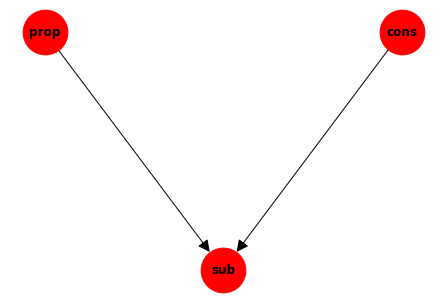

In [ ]:
sub = Subtract(links=[Constant(1, name='cons'), Proportional(10, name='prop')], name='sub')
import os
if os.name=='nt':
    sub.draw(node_size=2000)

## Running a Function

A function can be run simply by calling the variable.

In [ ]:
out = sub()
print(out)

1


A function can be also run in a loop with the run() method and provided the loop count.

In [ ]:
integrator = Integration(gain=9, slow=10)
integrator.add_link(sub)
o = integrator.run(steps=10, verbose=True)

0.900 1.710 2.439 3.095 3.686 4.217 4.695 5.126 5.513 5.862 

In [ ]:
integrator(verbose=True)

6.176 

6.17570463519

## Save and Load

Save a function to file.

In [ ]:
print(ws.get_config())
ws.save("ws.json")

{'type': 'WeightedSum', 'name': 'weighted_sum', 'value': 35.0, 'links': {0: 'constant', 1: 'constant1', 2: 'constant2'}, 'weights': [1.0, 1.0, 1.0]}


Create a function from file.

In [ ]:
wss = WeightedSum.load("ws.json")
assert ws.get_config() == wss.get_config() 
print(wss.get_config())

{'type': 'WeightedSum', 'name': 'weighted_sum', 'value': 35.0, 'links': {0: 'constant', 1: 'constant1', 2: 'constant2'}, 'weights': [1.0, 1.0, 1.0]}


# Setting Links
The next cell shows how a link is added to one function from another. In this case from an Integration function to a Constant function. So, whenever "integrator" runs it will get its input from "cons". 

In [ ]:
integrator = Integration(3, 10)
cons = Constant(5)
integrator.add_link(cons)
integrator.summary()

integration1 Integration | gain 3 slow 10  | 0 | links  constant3 


In [ ]:
UniqueNamer.getInstance().clear() # initialises the list of function names
integ = Integration(**{'name': 'myinteg', 'value': 1, 'gain': 20, 'slow': 100})
prop = Proportional(5, name="myprop")
integ.add_link(prop)
print(integ.get_config())
assert integ.get_config() == {'type': 'Integration', 'name': 'myinteg', 'value': 1, 'links': {0: 'myprop'}, 'gain': 20, 'slow': 100}

{'type': 'Integration', 'name': 'myinteg', 'value': 1, 'links': {0: 'myprop'}, 'gain': 20, 'slow': 100}


You can also define the link when you create the function, as in this example with "Proportional".

In [ ]:
const = Constant(1, name='const')
pr = Proportional(name='pr', links=const)
pr.summary()
assert pr() == 1

pr Proportional | gain 1 | 0 | links  const 


It can be the name of the linked function.

In [ ]:
pr = Proportional(gain=10, name='pr', links='const')
pr.summary()
assert pr() == 10

pr1 Proportional | gain 10 | 0 | links  const 


Or it can be a list of names.

In [ ]:
sub = Subtract(links=['const', 'pr'])
sub.summary()
assert sub()==0

subtract Subtract | 0 | links  const pr 


## Running a Fucntion
A function can simply be run by calling it, without any parameters. It will use whatever input was set by the links. It returns the result of the function. In this example it will be 5 \* 3 / 10, that is, input \* gain / slow.

In [ ]:
output = integrator()
print(output)
assert output == 1.5

1.5


## Array Input
The input to a function can be an array rather than a single value.

In [ ]:
integrator.set_value(np.array([1, 2, 4, 3]))
output = integrator()
print(output)
np.testing.assert_array_equal(output, [2.4, 3.3, 5.1, 4.2])

[2.4 3.3 5.1 4.2]


In [ ]:
print(integrator.get_config())

{'type': 'Integration', 'name': 'integration1', 'value': [2.4, 3.3, 5.1, 4.2], 'links': {0: 'constant3'}, 'gain': 3, 'slow': 10}


## Examples

### Configuration
Create a function from the configuration of another.

In [ ]:
#print(integrator.get_config())
integrator = Integration(3, 10)
cons = Constant(5)
integrator.add_link(cons)

inte = Integration.from_config(integrator.get_config())
print(inte())
print(inte.get_config())
target = {'type': 'Integration', 'name': 'integration', 'value': 1.5, 'links': {0: 'constant'}, 'gain': 3, 'slow': 10}
print(target)
assert inte.get_config() == target

1.5
{'type': 'Integration', 'name': 'integration', 'value': 1.5, 'links': {0: 'constant'}, 'gain': 3, 'slow': 10}
{'type': 'Integration', 'name': 'integration', 'value': 1.5, 'links': {0: 'constant'}, 'gain': 3, 'slow': 10}


In [ ]:
%nbdev_hide
from nbdev import *
notebook2script()

Converted 00_examples.ipynb.
Converted 01_putils.ipynb.
Converted 02_functions.ipynb.
Converted 03_nodes.ipynb.
Converted 04_hierarchy.ipynb.
Converted 05_environments.ipynb.
Converted 06_configurations.ipynb.
Converted index.ipynb.
